# Common geometric operations

This notebook consists of an introduction to common geometric operations of vector data in Python GIS ecosystem.

Geometric operations refer to a set of methods that can be used to process and analyze geometric features, like points, lines and polygons. In the context of geographic data analysis, these operations allow us, for instance, to ask questions about how two or more geographic objects relate to each other: Do they intersect, touch, or overlap? Are they adjacent to one another? How far apart are they?

In this notebook, multiple examples of common geometric manipulations will be shown. Data used will be the same as the previous notebook, the [census data track from Austin](https://github.com/Python-GIS-book/site/blob/master/source/part2/chapter-06/nb/data/Austin/austin_pop_2019.gpkg).

Let's prepare and read the file, once downloaded:

In [121]:
# Import required packages
from pathlib import Path
import geopandas as gpd

# Define the data path and read it
data_folder = Path("data", "Austin")
fp = data_folder / "austin_pop_density_2019.gpkg"

data = gpd.read_file(fp)
data.head()

,pop2019,tract,area_km2,pop_density_km2,geometry
0,6070.0,002422,4029.771797,1.506289,"POLYGON ((615643.487 3338728.496, 615645.477 3..."
1,2203.0,001751,1532.029989,1.437961,"POLYGON ((618576.586 3359381.053, 618614.33 33..."
2,7419.0,002411,3960.343857,1.873322,"POLYGON ((619200.163 3341784.654, 619270.849 3..."
3,4229.0,000401,2181.761674,1.938342,"POLYGON ((621623.757 3350508.165, 621656.294 3..."
4,4589.0,002313,2431.208488,1.887539,"POLYGON ((621630.247 3345130.744, 621717.926 3..."


The column of interest in this case is the geometry column, which contains the polygon geometries. Its data type is GeoSeries, and the individual geometries are ultimately shapely geometric objects (e.g. Point, LineString, Polygon), and we can use all of shapely’s tools for geometric manipulations directly via geopandas. 

In [122]:
# Check the kind of object of the column (polygons)
data["geometry"].head()

0    POLYGON ((615643.487 3338728.496, 615645.477 3...
1    POLYGON ((618576.586 3359381.053, 618614.33 33...
2    POLYGON ((619200.163 3341784.654, 619270.849 3...
3    POLYGON ((621623.757 3350508.165, 621656.294 3...
4    POLYGON ((621630.247 3345130.744, 621717.926 3...
Name: geometry, dtype: geometry

In [123]:
# Check data type of the geometry column
type(data["geometry"])

geopandas.geoseries.GeoSeries

Let’s first plot the original geometries. We can use the built-in *.plot()* function in geopandas to plot the geometries, and *matplotlib.pyplot* to turn off axis lines and labels:

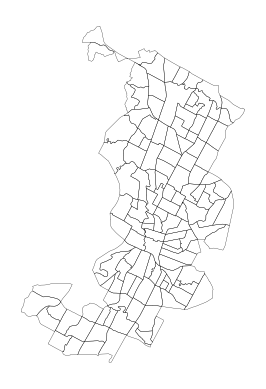

In [124]:
# Import the libraries
import matplotlib.pyplot as plt

# Plot
data.plot(facecolor="none", linewidth=0.2)
plt.axis("off")
plt.show()

#### Centroid

The centroid of a geometry is the geometric center of a given geometry (line, polygon or a geometry collection). Extracting the centroid of geometric features is useful in many cases. For example, to locate text labels in visualizations. We can extract the center point of each polygon via the centroid attribute of the geometry column. 

The data should be in a projected coordinate reference system when calculating the centroids. If trying to calculate centroids based on latitude and longitude information, geopandas will warn us that the results are incorrect. 

In [125]:
# Check the coordinate reference system (crs)
data.crs.name

'WGS 84 / UTM zone 14N'

In [126]:
# Check the centroids
data["geometry"].centroid.head()

0     POINT (616990.19 3339736.002)
1    POINT (619378.303 3359650.002)
2    POINT (620418.753 3342194.171)
3    POINT (622613.506 3351414.386)
4    POINT (622605.359 3343869.554)
dtype: geometry

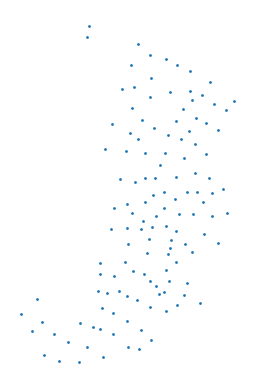

In [127]:
# Plot the centroids
data.centroid.plot(markersize=1)

plt.axis("off")
plt.show()

#### Unary union

A unary union operation combines multiple geometric objects into a single, unified geometric shape. This can be useful, for example, for visualizing the outlines of a study area. The *.union_all()* returns a single geometry object. The *.union_all()* method returns a shapely polygon object out of the results:

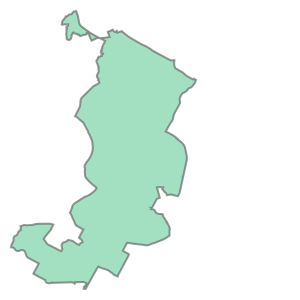

In [128]:
# Unary union with the previous data
data.union_all()

It is also possible to merge geometries using a method called *.dissolve()* that returns a GeoDataFrame as an output, with aggregated attribute information. Both the *.union_all()* and the *.dissolve()* support two different kind of algorithms to form the merged geometry: **unary** (the default) and **coverage** which is optimized for non-overlapping polygons and can be significantly faster to compute. Because the Austin data used for these examples does not have any overlapping polygons, we can test how merging the geometries work with the **coverage** algorithm:

In [129]:
# Merge geometries using coverage algorithm
dissolved = data.dissolve(method="coverage")
dissolved.head()

,geometry,pop2019,tract,area_km2,pop_density_km2
0,"MULTIPOLYGON (((618353.957 3340531.111, 618350...",6070.0,002422,4029.771797,1.506289


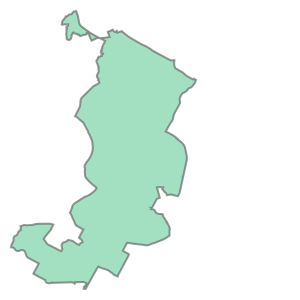

In [130]:
# Get the shapely geometry
dissolved.geometry[0]

As a result, the dissolved variable now contains the merged geometry as well as the attribute information associated with it. When looking at the returned geometry, we can see that it is identical to the one returned by *.union_all()* method. 

#### Bounding polygon

A bounding polygon is the smallest rectangular polygon that encloses a given geometry or a set of geometries. The bounding polygon is often used in spatial operations for preliminary filtering because it provides a computationally simple way to test for possible intersections or proximities between geometries that can be used to select data. In a GeoDataFrame, we can easily return the minimum axis-aligned bounding rectangle of geometries by using the *.envelope* attribute which returns the bounding rectangle for each geometry:

In [131]:
# Obtain the bounding polygon for each geometry
data.envelope.head()

0    POLYGON ((615643.487 3337909.895, 618358.033 3...
1    POLYGON ((618529.497 3358797, 620192.632 33587...
2    POLYGON ((619198.456 3340875.421, 621733.88 33...
3    POLYGON ((621599.087 3350329.32, 623714.366 33...
4    POLYGON ((621630.247 3343015.679, 624133.189 3...
dtype: geometry

In order to get the bounding rectangle for the whole layer, we first create an union of all geometries using the *.union_all()* method, and then extract the bounding rectangle for that polygon using the *.envelope*:

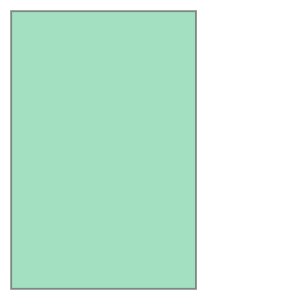

In [132]:
# Obtain the bounding rectangle
data.union_all().envelope

The corner coordinates of the bounding box for a GeoDataFrame can be obtained via the **total_bounds** attribute:

In [133]:
# Obtain corner coordinates of the bounding rectangle
data.total_bounds

array([ 608125.39434001, 3337909.89495403,  629828.38846075,
       3370513.6825782 ])

Or you can obtain the bounding coordinates of each feature with the **bounds** attribute:

In [134]:
# Obtain bounding coordinates of each feature
data.bounds.head()

,minx,miny,maxx,maxy
0,615643.487492,3.337910e+06,618358.032738,3.341257e+06
1,618529.497100,3.358797e+06,620192.631882,3.360614e+06
2,619198.455980,3.340875e+06,621733.879615,3.343443e+06
3,621599.086586,3.350329e+06,623714.365506,3.352436e+06
4,621630.247042,3.343016e+06,624133.188692,3.345131e+06


Similarly, it is possible to get the minimum rotated rectangle and minimum bounding circle with geopandas by using the *.minimum_rotated_rectangle()* and *.minimum_bounding_circle()* methods respectively. Here, we first merge all the geometries using the *.dissolve()* method as shown previously, and then use the merged geometry for getting the minimum bounding polygon.

The minimum rotated rectangle can rotate around the input geometries and aims to encircle them as tightly as possible. The minimum bounding circle creates a circle around the geometries in a way that each geometry is enclosed by the circle. Depending on the use case, all of these methods may come handy when working with geographic data.

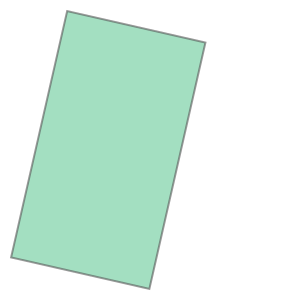

In [135]:
# Obtain the minimum rotated rectangle
data.dissolve().minimum_rotated_rectangle().geometry[0]

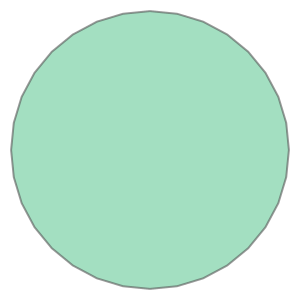

In [136]:
# Obtain the minimum bounding circle
data.dissolve().minimum_bounding_circle().geometry[0]

#### Convex hull

A convex hull represents the smallest possible polygon that contains all points in an object. Imagine stretching a rubber band around a set of points. Once released, the rubber band would snap into the shape of the convex hull, which wraps around the outermost points. 

In geopandas, we can use an attribute *.convex_hull* to return the convex hull of geometries. Similarly as with unary union, if we apply the convex hull method on the whole GeoDataFrame, we will get a GeoSeries containing a convex hull for each polygon separately:

In [137]:
# Obtain the convex geometries of the data
data.convex_hull.head()

0    POLYGON ((616870.883 3337909.895, 616852.964 3...
1    POLYGON ((619496.705 3358797, 618962.703 33590...
2    POLYGON ((619848.5 3340875.421, 619811.394 334...
3    POLYGON ((622145.426 3350329.32, 622132.429 33...
4    POLYGON ((623931.77 3343015.679, 622426.307 33...
dtype: geometry

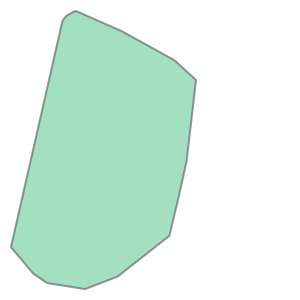

In [138]:
# Create the convex hull figure
data.union_all().convex_hull

#### Concave hull

A concave hull is a polygon that encloses a set of points but, unlike the convex hull, is allowed to have concavities. In simpler terms, while a convex hull wraps around the outermost points in the tightest convex manner (like a stretched rubber band), a concave hull can bend inward to more closely follow the distribution of the points, providing a boundary that might be more representative of the actual shape of the dataset.

In [139]:
# Obtain the concave GeoSeries hull of each polygon
data.concave_hull().head()

0    POLYGON ((616686.447 3341251.083, 616689.559 3...
1    POLYGON ((619414.904 3360602.695, 619418.528 3...
2    POLYGON ((620165.029 3343417.634, 620177.845 3...
3    POLYGON ((622361 3352408.88, 622364.565 335241...
4    POLYGON ((621654.405 3344983.596, 621630.247 3...
dtype: geometry

To return the concave hull of all geometries though, an extra step is needed as this functionality is not included in **shapely**, only in **geopandas**. We first use *.dissolve()* method which does similar thing as *.union_all()* but returns a GeoDataFrame as a result before calling the concave_hull() function:

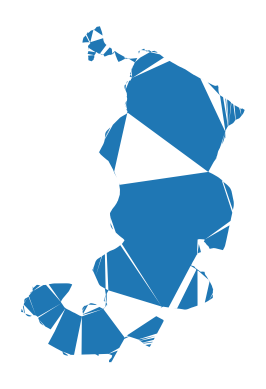

In [140]:
# Obtain the concave hull and plot
concave_hull = data.dissolve().concave_hull()
concave_hull.plot()

plt.axis("off")
plt.show()

The exact shape of the obtained concave hull has been simplified, but the shape looks quite weird and has gaps between the shapes. Because calculating the concave hull is a much more complicated operation than the previous ones, there are actually a couple of parameters which we can use to control the shape of the output. Parameters ratio and allow_holes can be used in situations where the convex hull is too general or doesn’t provide a realistic boundary for a set of points, like when capturing the outline of irregularly shaped clusters. 

We can very easily improve the shape of the convex hull by adjusting the ratio parameter which accepts a value between 0.0 - 1.0. The higher the number, the fewer the number of vertices will be kept in the output:

In [141]:
# Create the GeoDataFrame of the union
gdf_union = data.dissolve()

# Ratio 0.05
concave_hull_a = gdf_union.concave_hull(ratio=0.05)

# Ratio 0.2
concave_hull_b = gdf_union.concave_hull(ratio=0.2)

# Ratio 0.5
concave_hull_c = gdf_union.concave_hull(ratio=0.6)

Text(0.5, 1.0, 'Ratio 0.5')

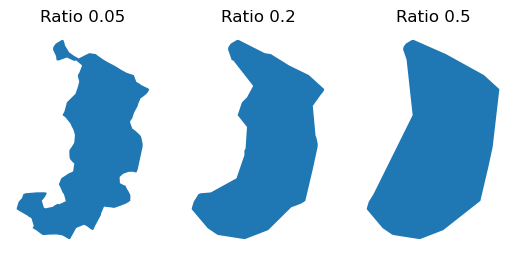

In [142]:
# Import matplotlib
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

# Plot the geometries side by side
concave_hull_a.plot(ax=ax1)
concave_hull_b.plot(ax=ax2)
concave_hull_c.plot(ax=ax3)

# Remove axis texts
ax1.axis("off")
ax2.axis("off")
ax3.axis("off")

# Add titles
ax1.set_title("Ratio 0.05")
ax2.set_title("Ratio 0.2")
ax3.set_title("Ratio 0.5")

#### Simplifying geometries

Geometric simplification is a useful process especially when visualizing data that contains very detailed geometries. geopandas uses a function called *.simplify()*. In comparison to the concave hull, this function also works with LineString geometries in addition to polygons. A tolerance parameter can be used to control the level of simplification. The units for this parameter follow the input coordinates, meaning that tolerance=1000 stands for 1000 meters because our input data is in a projected (metric) coordinate refence system. However, in case the input data would have lat/lon coordinates, the tolerance should be passed in as decimal degrees.

In [143]:
# Create the GeoDataFrame of the simplification
data.simplify(tolerance=1000).head()

0    POLYGON ((615643.487 3338728.496, 616689.559 3...
1    POLYGON ((619496.705 3358797, 619418.528 33606...
2    POLYGON ((619200.163 3341784.654, 620177.845 3...
3    POLYGON ((621623.757 3350508.165, 622387.916 3...
4    POLYGON ((621630.247 3345130.744, 624133.189 3...
dtype: geometry

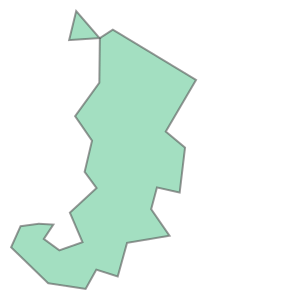

In [144]:
# Plot with union_all()
data.union_all().simplify(tolerance=1000)

#### Buffer

A buffer refers to a geometric operation that creates a zone around a given geometry, usually representing a certain distance from the shape. This zone/buffer can be visualized as an expanded area around the original shape, or conversely, a contracted area inside the shape if the buffer distance is negative. 

In geopandas, we can easily create buffers using the method *.buffer()* that can be applied to all geometries at once in a similar manner as our previous examples. The distance parameter in the *.buffer()* function defines the radius of the buffer (according to the coordinate reference system of the data). 

In [145]:
# Obtain the buffer GeoSeries hull of each polygon
data.buffer(1000).head()

0    POLYGON ((614643.602 3338713.368, 614644.329 3...
1    POLYGON ((617675.343 3359814.367, 617686.852 3...
2    POLYGON ((618338.249 3342291.708, 618373.228 3...
3    POLYGON ((620763.42 3351033.974, 620764.138 33...
4    POLYGON ((620643.457 3344968.74, 620632.393 33...
dtype: geometry

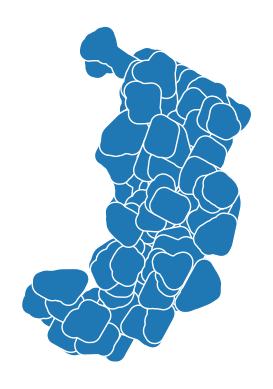

In [146]:
# Plot the buffered data
data.buffer(1000).plot(edgecolor="white")

plt.axis("off")
plt.show()

Buffer can be used with different geometry types, also with Point and LineString objects. It is good to notice that if you apply a buffer for points or polygons, the resulting geometry will always be a Polygon.

#### Dissolving and merging geometries

In geopandas, there is a method called *.dissolve()* that groups the data based on a specific attribute column and then produces an union of the geometries for each group in that attribute. At the same time, we can also get summary statistics of the attributes.

To demonstrate how dissolve works with our sample data, let’s create create a new column to our GeoDataFrame to indicate census tracts with above average population density. We can do this by adding a new empty column **dense** and adding values that indicate above and below average population densities per census tract:

In [147]:
# Create new colum with constant value
data["dense"] = 0

# Filter rows with above average pop density and update the column dense
data.loc[data["pop_density_km2"] > data["pop_density_km2"].mean(), "dense"] = 1

After this step, we should have multiple rows with numbers 0 and 1, where the number one indicates a densily populated area. 

In [148]:
# Check the value counts
data.dense.value_counts()

dense
0    86
1    44
Name: count, dtype: int64

Now we can use this dense column to dissolve the data into two groups using the *.dissolve()* function. At the same time, we can sum up the values in **pop2019** and the **area_km2** columns by using the *aggfunc* parameter. The aggregation requires that we select the numerical columns that we want to include in the output (which are indicated with the list of column names below):

In [149]:
# Conduct the aggregation
dissolved = data[["pop2019", "area_km2", "dense", "geometry"]].dissolve(
    by="dense", aggfunc="sum"
)
dissolved

,geometry,pop2019,area_km2
dense,,,
0,"MULTIPOLYGON (((614108.23 3339640.551, 614288....",368992.0,231131.494075
1,"MULTIPOLYGON (((612263.531 3338931.8, 612265.2...",242943.0,71234.570145


The dissolved data should have as many rows of data as there were unique values in the column: one row for each unique value. 

Our data have been compressed into two geometric objects and the column used for dissolving the data can now be found in the index. Attribute columns represent the sum of the values per group. 

We can reset the index and insert the categorical information into a new column after which we can do a quick visualization of the result:

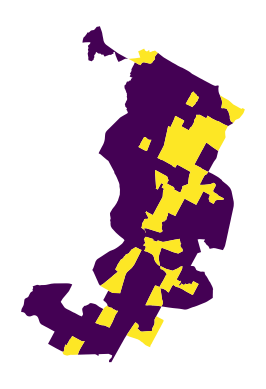

In [150]:
# Reset index
dissolved = dissolved.reset_index()

# Plot
dissolved.plot(column="dense")

plt.axis("off")
plt.show()

#### Changing the active geometry in a GeoDataFrame

In the previous examples, the manipulated geometries were not stored anywhere, just printed or plotted the results of the geometric operations directly to the screen. Thus, we want to discuss briefly about different ways to store the results of the geometric operations into GeoDataFrame, and how its active geometry can be changed or updated to represent the geometries in the data.

In some cases, such as when calculating the centroids in the previous examples, we might actually want to save the centroids into your GeoDataFrame. This is useful, because we can then continue processing or analysing the data based on these geometries. Storing and updating geometries in a GeoDataFrame can be done easily with geopandas, and in fact, we can have multiple columns that contain geometries. There are a couple of approaches to update the geometries of your GeoDataFrame:

1. Overwrite the existing geometries in the geometry column by storing the new (manipulated) geometries into it.

2. Create a new column and store the new geometries into this one. Then activate/set this column as the “active geometry” for your GeoDataFrame. In this way, we can have multiple simultaneous columns containing geometries in a GeoDataFrame.

Let's do option 1 first, doing a copy of the data and then overwriting the existing geometry with centroids:

In [151]:
# Make a copy
option_1 = data.copy()
option_1["geometry"].head(2)

0    POLYGON ((615643.487 3338728.496, 615645.477 3...
1    POLYGON ((618576.586 3359381.053, 618614.33 33...
Name: geometry, dtype: geometry

In [152]:
# Update the geometry column with centroids
option_1["geometry"] = option_1.centroid
print(option_1.head(2))

   pop2019   tract     area_km2  pop_density_km2  \
0   6070.0  002422  4029.771797         1.506289   
1   2203.0  001751  1532.029989         1.437961   

                         geometry  dense  
0   POINT (616990.19 3339736.002)      0  
1  POINT (619378.303 3359650.002)      0  


Now the geometries in the geometry column were replaced and populated with **Point** objects that represent the centroids of the polygons. With this approach, you cannot access the original polygon geometries anymore.

For the second option, we create a new column for storing the centroids and then use this column as the source for representing geometries of the given GeoDataFrame:

In [153]:
# Make a copy
option_2 = data.copy()

# Create the column with the centroids
option_2["centroid"] = data.centroid
option_2.head(2)

,pop2019,tract,area_km2,pop_density_km2,geometry,dense,centroid
0,6070.0,002422,4029.771797,1.506289,"POLYGON ((615643.487 3338728.496, 615645.477 3...",0,POINT (616990.19 3339736.002)
1,2203.0,001751,1532.029989,1.437961,"POLYGON ((618576.586 3359381.053, 618614.33 33...",0,POINT (619378.303 3359650.002)


This creates two columns in our GeoDataFrame that contain geometries. By default, geopandas always uses the geometry column as an active geometry (for example, when reading data from a file). However, we can easily change the active geometry with *.set_geometry()* method which can be used to tell geopandas to use another column with geometries as the source for geometry data:

In [154]:
# Use centroids as the GeoDataFrame geometries
option2 = option_2.set_geometry("centroid")
option2.head(2)

,pop2019,tract,area_km2,pop_density_km2,geometry,dense,centroid
0,6070.0,002422,4029.771797,1.506289,"POLYGON ((615643.487 3338728.496, 615645.477 3...",0,POINT (616990.19 3339736.002)
1,2203.0,001751,1532.029989,1.437961,"POLYGON ((618576.586 3359381.053, 618614.33 33...",0,POINT (619378.303 3359650.002)


In [155]:
# Check for the change of geometry
option2.geometry.name

'centroid'

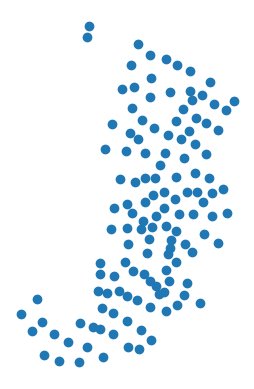

In [156]:
# Checking again by plotting the centroids
option2.plot()

plt.axis("off")
plt.show()